# Validating Regression Model: NY Crime Data in 2013

Using this data I'm going to build a regression model to predict property crimes. I'll add more features and check whether they are valuable or not. The goal here is prediction while all four assumptions of multivariable linear regression are true and make sure the model has good predictive validity for new data. 

### Proposed regression model is:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery + Burglary+Larceny+Motor Vehicle Theft $$



In [1033]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from scipy.stats import norm
from scipy import stats

import statsmodels.formula.api as smf

## 1. EDA | Data Cleaning | Feature Selection

In [1034]:
path = r'C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 2\datas\table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'
df = pd.read_excel(path, header = 4)


# rename the columns
df.rename(columns = {'Murder and\nnonnegligent\nmanslaughter':'Murder', 
                     'Property\ncrime':'Property_crime',
                    'Larceny-\ntheft': 'Larceny',
                    'Motor\nvehicle\ntheft': 'MV_theft'}, inplace = True)

# remove last 3 rows 
df.drop(df.iloc[348:, :].index, inplace = True)
df = df[['Property_crime','Population', 'Murder', 'Robbery', 'Larceny', 'Burglary', 'MV_theft']]
for col in df.columns:
    df[col] = df[col].astype(np.int64)
df.isnull().sum()

Property_crime    0
Population        0
Murder            0
Robbery           0
Larceny           0
Burglary          0
MV_theft          0
dtype: int64

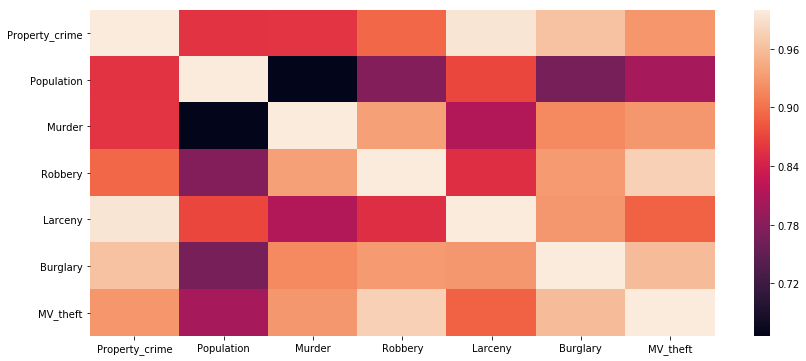

In [1072]:
# check the correlation of variables
plt.figure(figsize = (14,6))
sns.heatmap(df.corr(), xticklabels=True, yticklabels=True)
plt.show()

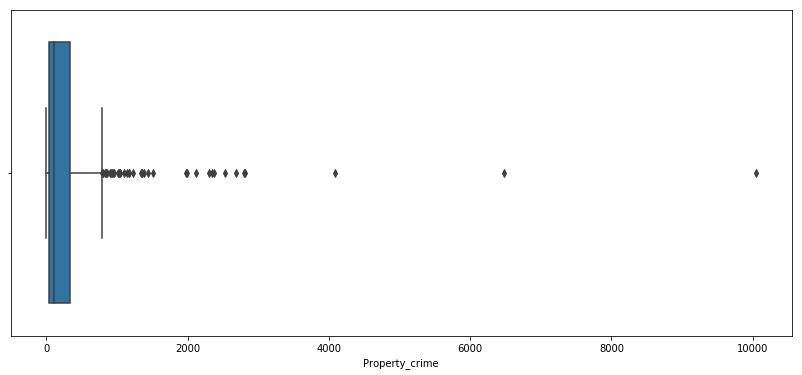

In [1075]:
# check for outliers in outcome variable
plt.figure(figsize=(14,6))
_ = sns.boxplot(df.Property_crime)
plt.show()

In [1037]:
# remove outliers 
# z-score method to remove outliers
#no_outliers = features.copy()
#z = np.abs(stats.zscore(no_outliers))
#threshold = 3
#features = features[(z < threshold).all(axis=1)]

outliers = df.nlargest(1, ['Property_crime']).index.tolist()
df.drop(index = outliers, axis = 0, inplace = True)

I select 7 features to fit the model and the only Population feature is a continuous variable. I'll check the distribution of this variable in order to normalize if needed.

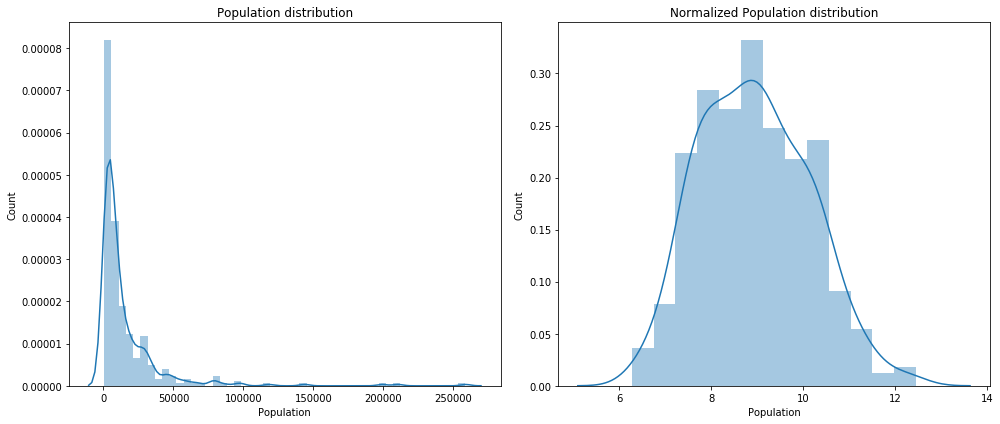

In [1038]:
# plot the Population distribution    
plt.figure(figsize = (14,6))
plt.subplot(121)
_ = sns.distplot(df.Population)
_.set(ylabel = 'Count', title = 'Population distribution')

# plot normalized Population distribution
plt.subplot(122)
_ = sns.distplot(np.log(df.Population))
_.set(ylabel = 'Count', title = 'Normalized Population distribution')
plt.tight_layout()

In [1039]:
# create a dataframe to hold features
features = pd.DataFrame()
features['property_crime'] = df['Property_crime']
features['murder'] = np.where(df['Murder']>=1, 1, 0)
features['robbery'] = np.where(df['Robbery']>=1, 1, 0)
features['burglary'] = np.where(df['Burglary']>=1, 1, 0)
features['mv_theft'] = np.where(df['MV_theft']>=1, 1, 0)
features['larceny'] = np.where(df['Larceny']>=1, 1, 0)
features['population'] = np.log(df['Population'])
features['population_squared'] = np.square(df.Population)
features.describe()

,property_crime,murder,robbery,burglary,mv_theft,larceny,population,population_squared
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,3.470000e+02
mean,385.752161,0.138329,0.599424,0.939481,0.731988,0.979827,8.935944,9.858407e+08
std,1034.369072,0.345743,0.490723,0.238790,0.443563,0.140795,1.189174,5.067232e+09
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.265301,2.766760e+05
25%,40.000000,0.000000,0.000000,1.000000,0.000000,1.000000,8.005359,8.982153e+06
50%,112.000000,0.000000,1.000000,1.000000,1.000000,1.000000,8.880029,5.165297e+07
75%,340.500000,0.000000,1.000000,1.000000,1.000000,1.000000,9.807003,3.298042e+08
max,12491.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.463768,6.697175e+10


## 2. Linear Regression Model

In [1040]:
# instantiate and fit the model
regr = linear_model.LinearRegression()
Y = features['property_crime']
X = features[['population','population_squared','murder','robbery', 'burglary','larceny', 'mv_theft']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 1.40102609e+02  1.61674168e-07  2.53149725e+02  6.60743380e+01
 -9.20625311e+01 -2.71701141e+01 -5.05246450e+00]

Intercept: 
 -983.3948550905029

R-squared:
0.8395403648134738


In [1041]:
# cross validation with 5 folds
cvs = cross_val_score(regr, X, Y, cv = 5)
print('Cross Validation 5 folds: {}'.format(cvs))
print('mean: {}, std: {}'.format(np.mean(cvs), np.std(cvs)))

Cross Validation 5 folds: [0.93860818 0.68199366 0.76065256 0.87692709 0.3066898 ]
mean: 0.7129742587964475, std: 0.22185187495827993


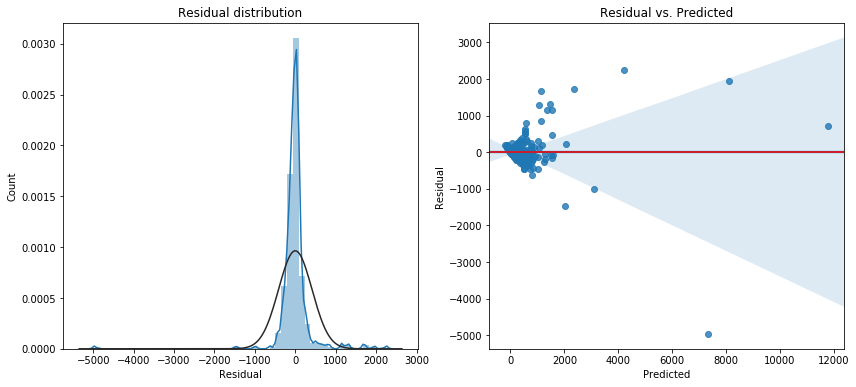

In [1042]:
# extract predicted values
predicted = regr.predict(X).ravel()

# Calculate the error, also called the residual.
actual = features['property_crime']
residual = actual - predicted

# plot residual distribution
plt.figure(figsize = (14, 6))
plt.subplot(121)
_ = sns.distplot(residual, fit = norm)
_.set(title = 'Residual distribution', xlabel = 'Residual', ylabel = 'Count')

# scatter plot residual vs. predicted
plt.subplot(122)
_ = sns.regplot(predicted, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Predicted', xlabel = 'Predicted', ylabel = 'Residual')

plt.show()


Residual distribution is normal as it supposed to be. The plot of residual vs. predicted shows that the model performs inaccurate as the number of property crime increases. If I remove the datapoints which look like as outliers, the R-square decreases to 0.61.

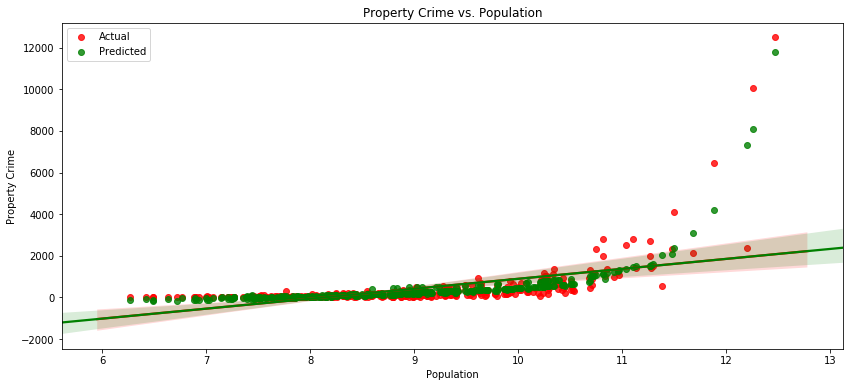

In [1043]:
# plot predicted vs actual
y_pred = regr.predict(X)

# plot predicted property crime vs. actual property crime
plt.figure(figsize = (14,6))
_ = sns.regplot(features.population, Y, color = 'r', label = 'Actual')
_ = sns.regplot(features.population, y_pred, color = 'g', label = 'Predicted')
_.set(xlabel = 'Population', ylabel = 'Property Crime', title  = 'Property Crime vs. Population' )
plt.legend()
plt.show()


In the last plot green dots depict Predicted property crimes while red dots show Actual property crimes. Green dots follow red ones and with R-squared 0.83 we can say that the model performs not bad, but it could be better. 
Above I calculated cross-validation with 5 folds and the result was not what I wanted. The model is not perfect and we can have very low scores due to the datapoints which do not lie on any line as I expect.

## 3. Ordinary Least Square

In [1044]:
# write out the model formula
formula = 'property_crime ~ population+population_squared+murder+robbery+burglary+mv_theft+larceny'

lm = smf.ols(formula = formula, data = features).fit()

print('Parameters \n', lm.params, '\n')
print('P-values \n', lm.pvalues, '\n')
print('R-square: {}'.format(lm.rsquared))

Parameters 
 Intercept            -9.833949e+02
population            1.401026e+02
population_squared    1.616741e-07
murder                2.531497e+02
robbery               6.607434e+01
burglary             -9.206253e+01
mv_theft             -5.052465e+00
larceny              -2.717011e+01
dtype: float64 

P-values 
 Intercept              2.053599e-04
population             3.663730e-06
population_squared    1.029590e-103
murder                 9.815493e-04
robbery                2.646368e-01
burglary               4.236627e-01
mv_theft               9.342348e-01
larceny                8.820229e-01
dtype: float64 

R-square: 0.8395403648134637


From the p-values, we see the p-value for 'robbery', 'burglary', 'mv_theft' and 'larceny' is higher than .05, suggesting that all these features are not significant for the model and they do not adversely affect the R^2.

In [1046]:
features.drop(['robbery', 'burglary', 'larceny', 'mv_theft'], axis = 1, inplace = True)

In [1048]:
# write out the model formula
formula = 'property_crime ~ population+population_squared+murder'

lm = smf.ols(formula = formula, data = features).fit()

print('Parameters \n', lm.params, '\n')
print('P-values \n', lm.pvalues, '\n')
print('R-square: {}'.format(lm.rsquared))

Parameters 
 Intercept            -1.121654e+03
population            1.467985e+02
population_squared    1.614452e-07
murder                2.636026e+02
dtype: float64 

P-values 
 Intercept              3.937466e-08
population             4.148783e-10
population_squared    1.284927e-106
murder                 5.485955e-04
dtype: float64 

R-square: 0.838548776594364


In [1049]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     593.8
Date:                Thu, 14 Feb 2019   Prob (F-statistic):          2.05e-135
Time:                        13:28:16   Log-Likelihood:                -2584.2
No. Observations:                 347   AIC:                             5176.
Df Residuals:                     343   BIC:                             5192.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1121.6544    199.548     -5.621      0.000   -1514.147    -729.162
population           146.7985     22.811      6.435      0.000     101.931     191.666
population_squared  1.614e-07   4.97e-09     32.462      0.000    1.52e-07    1.71e-07
murder               263.6026     75.559      3.489      0.001     114.986     412.219
==============================================================================
Omnibus:                      348.384   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58749.624
Skew:                          -3.601   Prob(JB):                         0.00
Kurtosis:                      66.336   Cond. No.                     4.67e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model Validation on California Crime Data 2013

In [1065]:
path1 = r'C:\Users\hafeez_poldz\Desktop\Thinkful\Unit 2\datas\table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls'
df_cali = pd.read_excel(path, header = 4)

# rename the columns
df_cali.rename(columns = {'Murder and\nnonnegligent\nmanslaughter':'Murder', 
                     'Property\ncrime':'Property_crime',
                    'Larceny-\ntheft': 'Larceny',
                    'Motor\nvehicle\ntheft': 'MV_theft'}, inplace = True)

# remove missing values
df_cali= df_cali[np.isfinite(df_cali['Property_crime'])]

for col in ['Population', 'Murder', 'Robbery', 'Property_crime', 'Larceny', 'MV_theft', 'Burglary']:
    df_cali[col] = df_cali[col].astype(np.int64)
    
    # remove outliers
outliers = df_cali.nlargest(1, ['Property_crime']).index.tolist()
df_cali.drop(index = outliers, axis = 0, inplace = True)

# create a dataframe to hold features
features_cali = pd.DataFrame()
features_cali['property_crime'] = df_cali['Property_crime']
features_cali['murder'] = np.where(df_cali['Murder']>=1, 1, 0)
features_cali['population'] = np.log(df_cali['Population'])
features_cali['population_squared'] = np.square(df_cali.Population)


print(features_cali.isnull().sum())
print(features_cali.shape)
features_cali.describe()


property_crime        0
murder                0
population            0
population_squared    0
dtype: int64
(347, 4)


,property_crime,murder,population,population_squared
count,347.000000,347.000000,347.000000,3.470000e+02
mean,385.752161,0.138329,8.935944,9.858407e+08
std,1034.369072,0.345743,1.189174,5.067232e+09
min,0.000000,0.000000,6.265301,2.766760e+05
25%,40.000000,0.000000,8.005359,8.982153e+06
50%,112.000000,0.000000,8.880029,5.165297e+07
75%,340.500000,0.000000,9.807003,3.298042e+08
max,12491.000000,1.000000,12.463768,6.697175e+10


In [1066]:
# instantiate and fit our model
regr = linear_model.LinearRegression()
Y_cali = features_cali['property_crime']
X_cali = features_cali[['population','population_squared','murder']]
regr.fit(X_cali, Y_cali)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_cali, Y_cali))


Coefficients: 
 [1.46798529e+02 1.61445187e-07 2.63602648e+02]

Intercept: 
 -1121.654280733596

R-squared:
0.8385487765943668


In [1067]:
cvs = cross_val_score(regr, X_cali, Y_cali, cv = 5)
print('Cross Validation 5 folds: {}'.format(cvs))
print('mean: {}, std: {}'.format(np.mean(cvs), np.std(cvs)))

Cross Validation 5 folds: [0.93786928 0.67605101 0.75332927 0.87671148 0.30673417]
mean: 0.7101390447425746, std: 0.22152666527036077


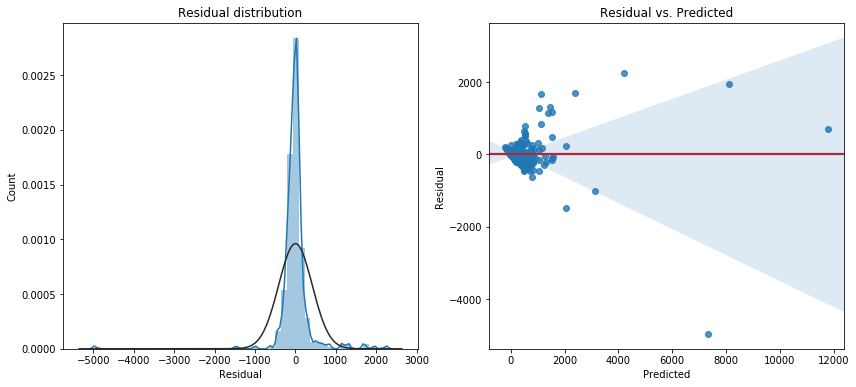

In [1068]:
# extract predicted values
predicted = regr.predict(X_cali).ravel()

# Calculate the error, also called the residual.
actual = features_cali['property_crime']
residual = actual - predicted

# plot residual distribution
plt.figure(figsize = (14, 6))
plt.subplot(121)
_ = sns.distplot(residual, fit = norm)
_.set(title = 'Residual distribution', xlabel = 'Residual', ylabel = 'Count')

# scatter plot residual vs. predicted
plt.subplot(122)
_ = sns.regplot(predicted, residual)
_.axhline(y=0, color = 'r')
_.set(title = 'Residual vs. Predicted', xlabel = 'Predicted', ylabel = 'Residual')

plt.show()


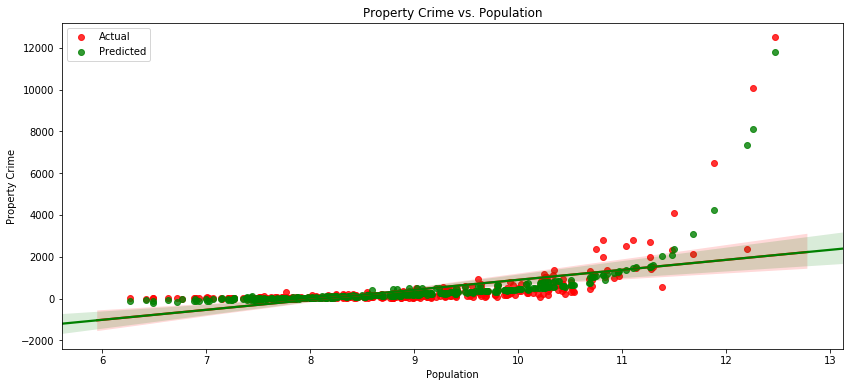

In [1070]:
# plot predicted vs actual
y_pred_cali = regr.predict(X_cali)

# plot predicted property crime vs. actual property crime
plt.figure(figsize = (14,6))
_ = sns.regplot(features_cali.population, Y, color = 'r', label = 'Actual')
_ = sns.regplot(features_cali.population, y_pred, color = 'g', label = 'Predicted')
_.set(xlabel = 'Population', ylabel = 'Property Crime', title  = 'Property Crime vs. Population' )
plt.legend()
plt.show()


The model performs successfully at predicting the property crime in California as well. I could say California and New York have almost the same degree of property crime. In this model, I have only one continuous variable and the model relies on this feature heavily. With the more population comes more property crime. 